# Functioning Convolutional Autoencoder

In [1]:
# Load libraries
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import os

In [2]:
# Image dimensions in dataset:
# 200x200x3

dataset_folder = "C:/Users/miros/Datasets/faces/normalized_images"
test_folder = "C:/Users/miros/Projects/Hair color classification/testing_data_augmented"

## Assign photos to dataset

In [3]:
# Functions to assign photos to dataset

def load__grayscale_images_to_dataset(folder):
    dataset = []
    for i, filename in enumerate(os.listdir(folder)): # "Enumerate" is a way to index in a for loop
        image = Image.open(folder + "/{}".format(filename))
        image_grayscale = ImageOps.grayscale(image)
        data = np.asarray(image_grayscale)
        dataset.append(data)
    return dataset

def load_RGB_images_to_dataset(folder):
    dataset = []
    for i, filename in enumerate(os.listdir(folder)): # "Enumerate" is a way to index in a for loop
        image = Image.open(folder + "/{}".format(filename))
        data = np.asarray(image)
        dataset.append(data)
    return dataset

In [4]:
x_train = load_RGB_images_to_dataset(dataset_folder)
x_test = load_RGB_images_to_dataset(test_folder)

x_train = np.array(x_train) # Convert dataset to numpy array
x_test = np.array(x_test) # Convert test set to numpy array

## Normalize images

In [5]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
print(x_train.shape)
print(x_test.shape)

(1406, 200, 200, 3)
(35, 200, 200, 3)


## Define autoencoder model

**Encoder:**

In [7]:
conv_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([200,200,3], input_shape=[200,200,3]),
    tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    tf.keras.layers.MaxPool2D(pool_size=2)
])

**Decoder:**

In [8]:
conv_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='selu', input_shape=[25,25,64]),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    tf.keras.layers.Reshape([200,200,3])
])

**Autoencoder:**

In [9]:
# Combine encoder and decoder together using Sequential model:

conv_ae = tf.keras.models.Sequential([
    conv_encoder,
    conv_decoder
])

**Optimize autoencoder model:**

In [10]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
conv_ae.compile(opt, loss='mse', metrics=['accuracy'])

## Train model:

In [11]:
conv_ae.fit(x_train, x_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
40/40 [==============================] - 30s 668ms/step - loss: 0.0743 - accuracy: 0.6137 - val_loss: 0.0188 - val_accuracy: 0.8208
Epoch 2/10
40/40 [==============================] - 31s 767ms/step - loss: 0.0142 - accuracy: 0.8383 - val_loss: 0.0087 - val_accuracy: 0.8416
Epoch 3/10
40/40 [==============================] - 31s 784ms/step - loss: 0.0080 - accuracy: 0.8522 - val_loss: 0.0070 - val_accuracy: 0.8505
Epoch 4/10
40/40 [==============================] - 29s 726ms/step - loss: 0.0065 - accuracy: 0.8609 - val_loss: 0.0058 - val_accuracy: 0.8605
Epoch 5/10
40/40 [==============================] - 27s 679ms/step - loss: 0.0054 - accuracy: 0.8755 - val_loss: 0.0051 - val_accuracy: 0.8672
Epoch 6/10
40/40 [==============================] - 28s 694ms/step - loss: 0.0049 - accuracy: 0.8808 - val_loss: 0.0046 - val_accuracy: 0.8735
Epoch 7/10
40/40 [==============================] - 28s 711ms/step - loss: 0.0045 - accuracy: 0.8810 - val_loss: 0.0044 - val_accuracy: 0.8752

# Predict/Recreate images

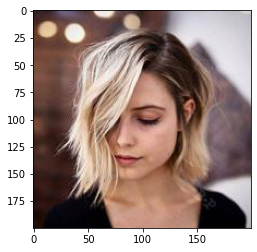

In [12]:
import matplotlib.pyplot as plt

plt.imshow(x_test[0])

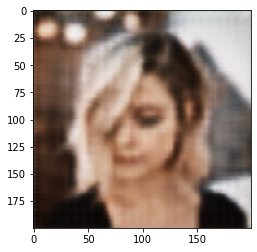

In [13]:
ae = conv_ae.predict([x_test[0].reshape(-1, 200, 200, 3)])[0] # Reshape is needed because autoencoder model expects batches

plt.imshow(ae)

## Encoder last layer output visualization

In [14]:
# Get encoder layer outputs:
layer_outputs = [layer.output for layer in conv_encoder.layers]

layer_outputs

[<KerasTensor: shape=(None, 200, 200, 3) dtype=float32 (created by layer 'reshape')>,
 <KerasTensor: shape=(None, 200, 200, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 100, 100, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 100, 100, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 50, 50, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 50, 50, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 25, 25, 64) dtype=float32 (created by layer 'max_pooling2d_2')>]

In [15]:
layer_names = [layer.name for layer in conv_encoder.layers]

layer_names

['reshape',
 'conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2']

**Create visualization model:**

In [16]:
visualization_model = tf.keras.models.Model(inputs=conv_encoder.input, outputs=layer_outputs)

**Feed a test image to the visualization model:**

In [17]:
feature_maps = visualization_model.predict([x_test[0].reshape(-1, 200, 200, 3)])

In [18]:
for feature_map in feature_maps:
    print(f"Class: {type(feature_map)} with shape {feature_map.shape}")

Class: <class 'numpy.ndarray'> with shape (1, 200, 200, 3)
Class: <class 'numpy.ndarray'> with shape (1, 200, 200, 16)
Class: <class 'numpy.ndarray'> with shape (1, 100, 100, 16)
Class: <class 'numpy.ndarray'> with shape (1, 100, 100, 32)
Class: <class 'numpy.ndarray'> with shape (1, 50, 50, 32)
Class: <class 'numpy.ndarray'> with shape (1, 50, 50, 64)
Class: <class 'numpy.ndarray'> with shape (1, 25, 25, 64)


In [19]:
print(f"The feature map of {layer_names[6]} (last layer) has a shape of {feature_maps[6].shape}")

The feature map of max_pooling2d_2 (last layer) has a shape of (1, 25, 25, 64)


**Show visualization from the "max_pooling2d_2" layer:**

Note: This is the last layer in the encoder.

(1, 25, 25, 64)
<class 'numpy.ndarray'>


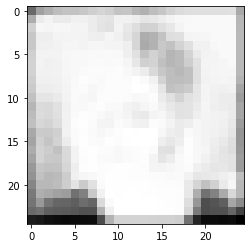

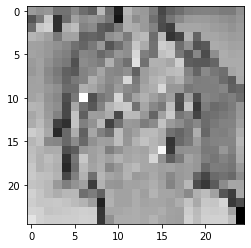

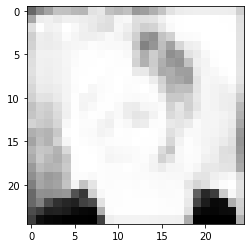

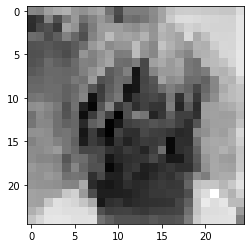

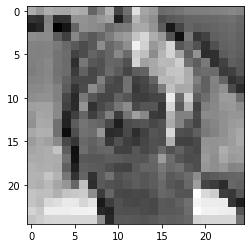

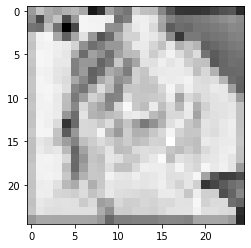

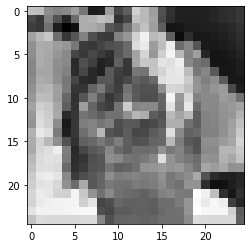

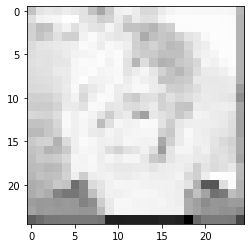

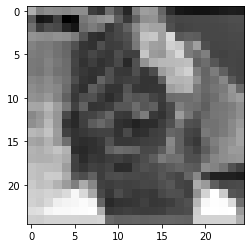

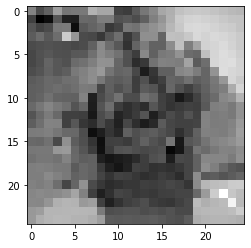

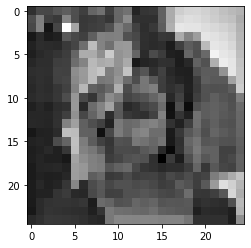

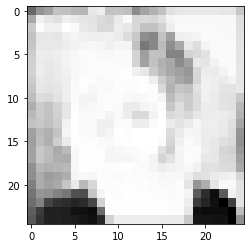

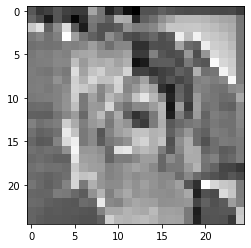

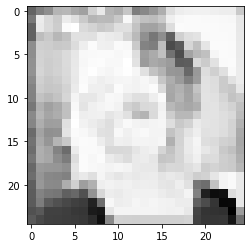

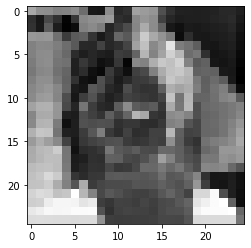

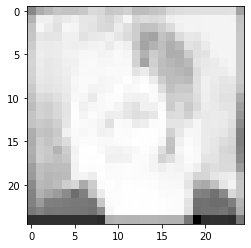

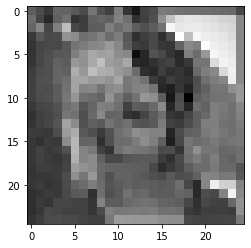

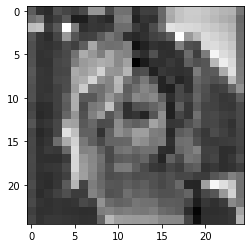

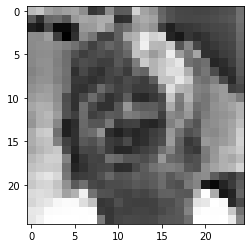

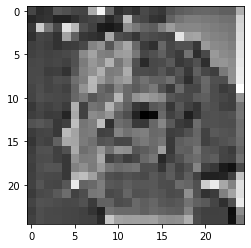

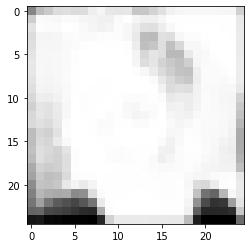

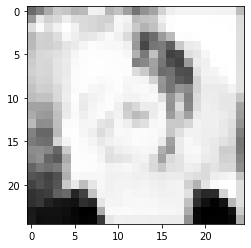

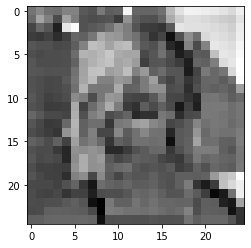

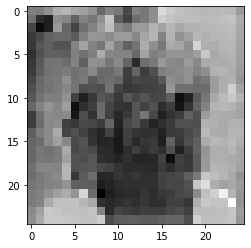

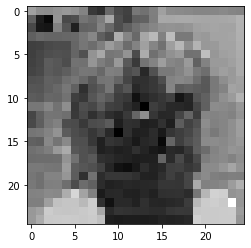

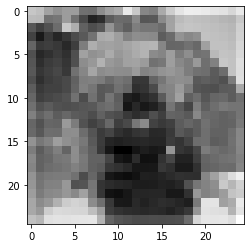

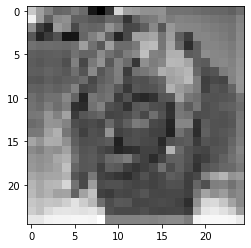

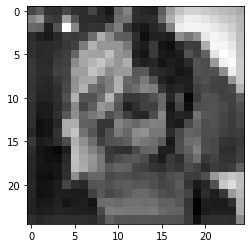

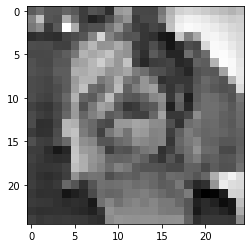

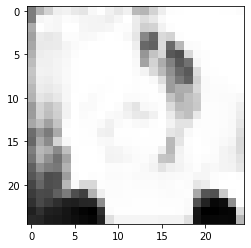

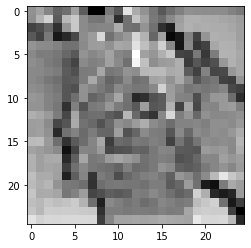

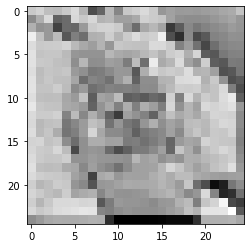

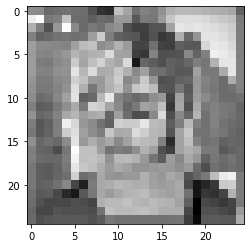

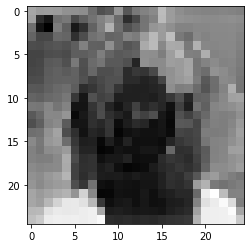

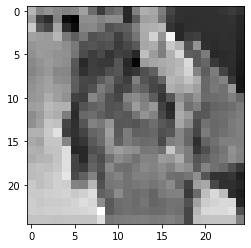

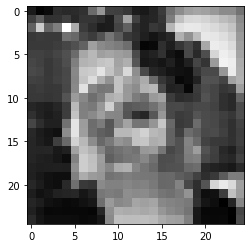

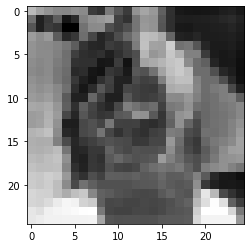

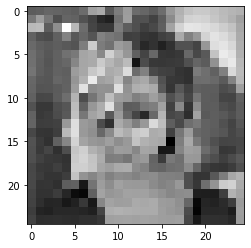

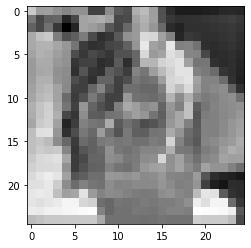

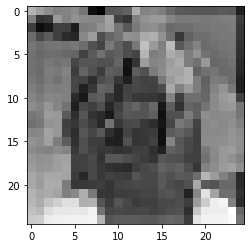

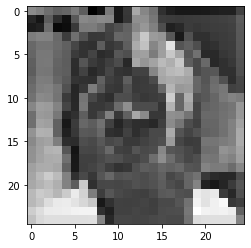

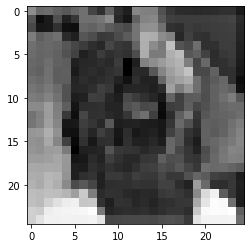

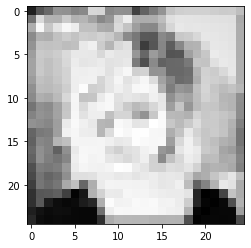

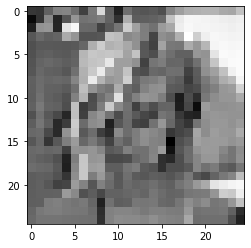

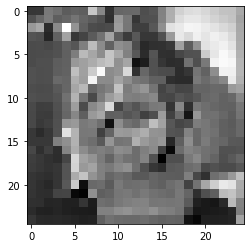

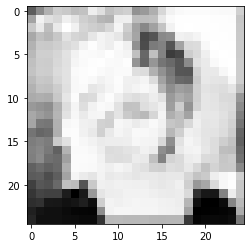

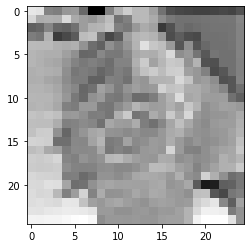

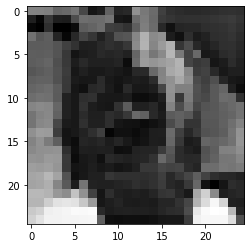

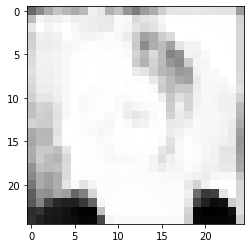

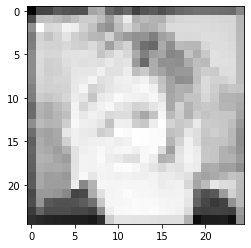

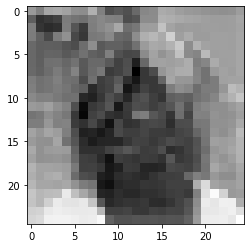

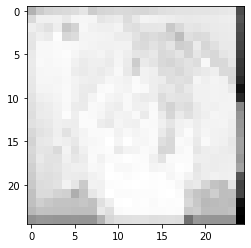

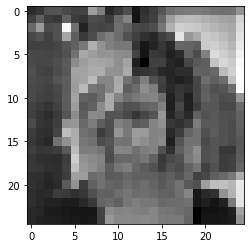

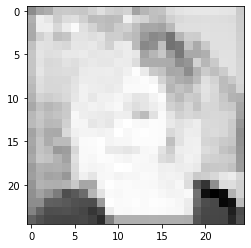

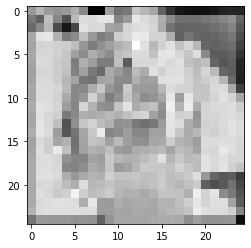

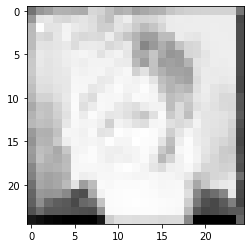

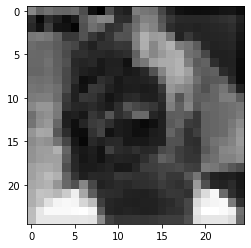

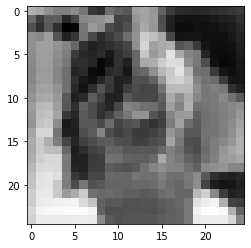

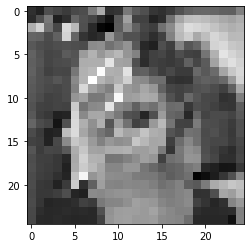

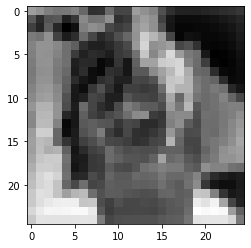

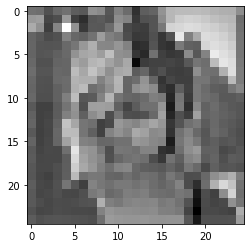

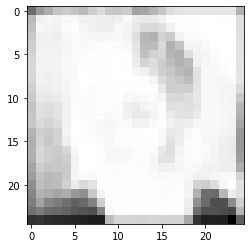

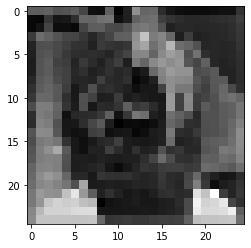

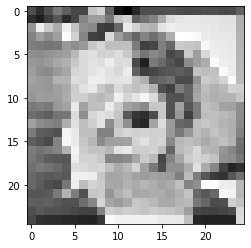

In [20]:
# Assign the output of "max_pooling2d_2" layer to a variable
encoder_visualization_img = feature_maps[6]

print(encoder_visualization_img.shape)
print(type(encoder_visualization_img))

k = encoder_visualization_img.shape[-1] # Should return integer 64
for i in range(k):
    feature_image = encoder_visualization_img[0, :, :, i]
    plt.imshow(feature_image, cmap='binary')
    plt.show()